Coupling map:


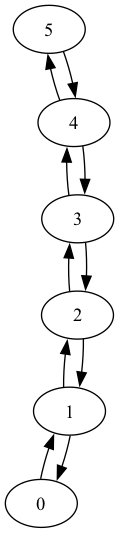

In [1]:
# All relevant imports

from spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt

# Specifying system params
num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"] # For each of the six qubits
rotation_parameters = ParameterVector("θ", num_qubits) # Qiskit symbolic vector, circuit context
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

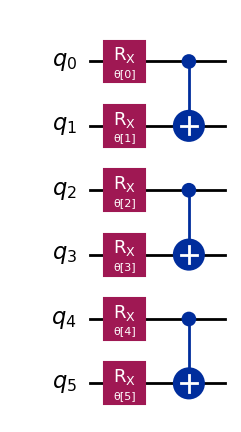

In [2]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

In [3]:
# Seeding

seed = 20983
np.random.seed(seed) # This is sufficient as we use numpy for all randomness

Parameter dictionary:
 {ParameterVectorElement(θ[0]): 4.665466064857704, ParameterVectorElement(θ[1]): 3.4958331672967256, ParameterVectorElement(θ[2]): 1.1607433119572852, ParameterVectorElement(θ[3]): 3.9246618340416872, ParameterVectorElement(θ[4]): 0.8148633976847353, ParameterVectorElement(θ[5]): 6.110646020345377}


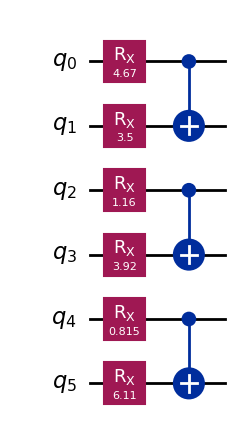

In [4]:
# Plugging in some example values
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

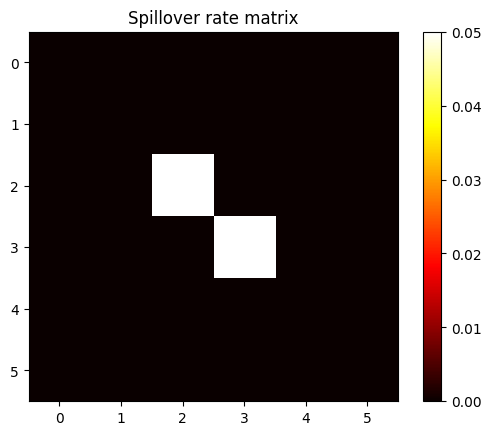

In [65]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
# gamma_matrix[0, 1] = 0.05  # γ_0->1
gamma_matrix[0, 3] = 0.0  # γ_0->3
# gamma_matrix[1, 2] = 0.05  # γ_1->2
gamma_matrix[2, 2] = 0.05  # γ_2->2
gamma_matrix[3, 3] = 0.05  # γ_3->3
# gamma_matrix[2, 3] = 0.05  # γ_2->3
# gamma_matrix[3, 2] = 0.05  # γ_3->2
gamma_matrix[4, 3] = 0.0  # γ_4->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
# gamma_matrix = 0.01 * np.round(np.random.rand(num_qubits, num_qubits), 3)
# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

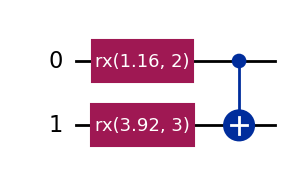

In [66]:
# Constructing the effective circuit to optimize on

pm = PassManager(
    [
        LocalSpilloverNoiseAerPass(
            spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
            target_subsystem=(2, 3),
        )
    ]
)
qc_noisy = pm.run(circuit.assign_parameters(param_dict))
qc_noisy.draw("mpl")

In [67]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

print("Rotation angles:", rotation_angles)

Rotation angles: [4.66546606 3.49583317 1.16074331 3.92466183 0.8148634  6.11064602]


In [68]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': 'b8e888c236414382ab1be8c8755f9fd6',
   'operations': ['rx(1.16, 2)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99957899+0.j        , 0.        -0.02901451j],
              [0.        -0.02901451j, 0.99957899+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0,)]},
  {'type': 'qerror',
   'id': 'ad2f24c11f4e4bc4891bf798ce3d8f2e',
   'operations': ['rx(3.92, 3)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.99519043+0.j       , 0.        -0.0979592j],
              [0.        -0.0979592j, 0.99519043+0.j       ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

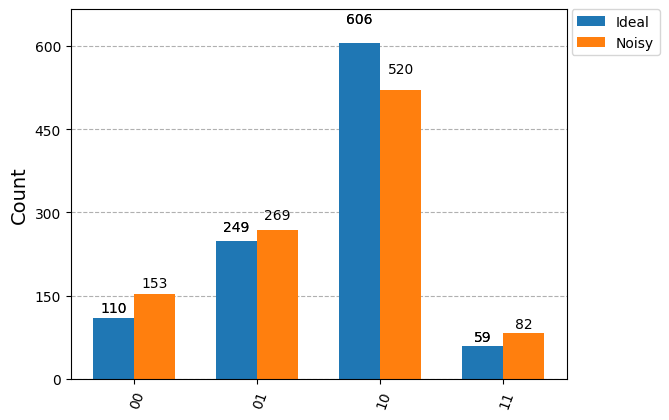

In [69]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [70]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [71]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9916561859487066

In [72]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate

def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        *new_params[:3],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [73]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-1.0, high=1.0, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [0, 1]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=None,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32,
        n_reps=[3, 6, 9, 12],
        n_shots=100,
        sampling_paulis=200,
        c_factor=1,
        seed=seed+6,
    ),
    reward_config="channel",
    env_metadata=env_metadata,
)
q_env = ContextAwareQuantumEnvironment(
    q_env_config,
    circuit_context=qc_noisy,  # Pass the circuit already transpiled through custom pass
)

In [74]:
rescaled_env = RescaleAndClipAction(q_env, -1, 1)

In [75]:
print(np.linspace(1, 101, 21, dtype=np.int8))

[  1   6  11  16  21  26  31  36  41  46  51  56  61  66  71  76  81  86
  91  96 101]


Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9916561859487066
Sending Sampler job...
Time for running 0.040985107421875 seconds
Finished Sampler job
Reward (avg): 0.995625 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9916561859487066
Sending Sampler job...
Time for running 0.10833096504211426 seconds
Finished Sampler job
Reward (avg): 0.9325 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9916561859487066
Sending Sampler job...
Time for running 0.11700701713562012 seconds
Finished Sampler job
Reward (avg): 0.82375 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9916561859487066
Sending Sampler job...
Time for running 0.29539990425109863 seconds
Finished Sampler job
Reward (avg): 0.6775 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9916561859487066
Sending Sampler job...
Time for runnin

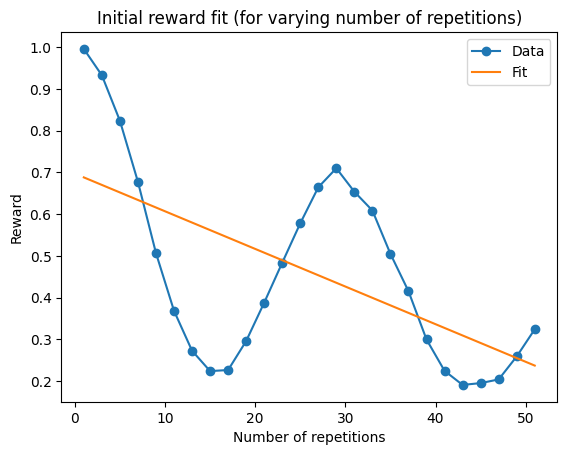

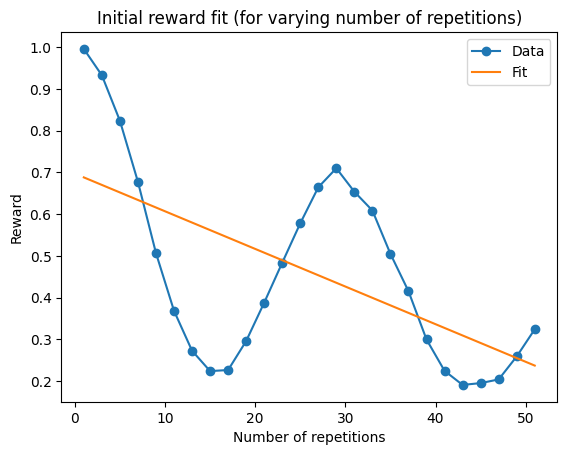

In [76]:
q_env.initial_reward_fit(
    np.zeros((1, 7)),
    ExecutionConfig(
        sampling_paulis=1000,
        n_shots=100,
        #n_reps=list(
        #    range(1, 100),
        #),
        n_reps=np.linspace(1, 51, 26, dtype=np.int8),
        dfe_precision=(1e-1, 0.1),
        seed=q_env_config.seed,
    ),
    update_fit_params=False,
    reward_method="cafe",
)

Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9921630325101866
Sending Estimator job...
Time for running 0.17010498046875 seconds
Finished Estimator job
Reward (avg): 0.6906993409962725 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9921630325101866
Sending Estimator job...
Time for running 0.4455111026763916 seconds
Finished Estimator job
Reward (avg): 0.5453705329327879 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9921630325101866
Sending Estimator job...
Time for running 0.43278002738952637 seconds
Finished Estimator job
Reward (avg): 0.7981781711047329 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9921630325101866
Sending Estimator job...
Time for running 0.48207783699035645 seconds
Finished Estimator job
Reward (avg): -0.1410969138274093 Std: 0.0
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities

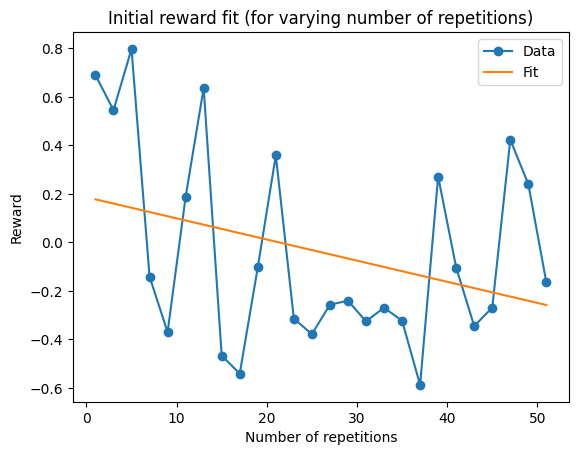

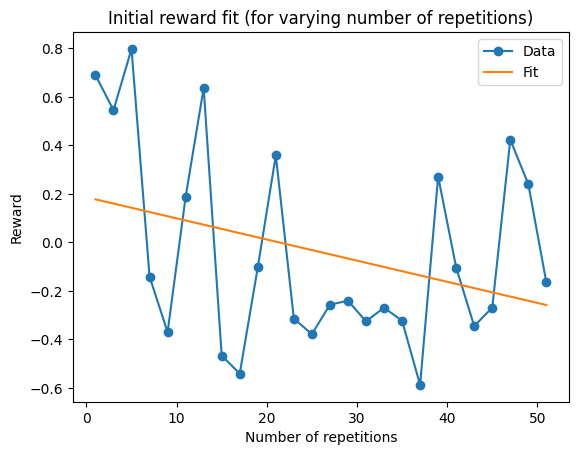

In [49]:
q_env.initial_reward_fit(
    np.zeros((1, 7)),
    ExecutionConfig(
        sampling_paulis=10000,
        n_shots=1000,
        #n_reps=list(
        #    range(1, 100),
        #),
        n_reps=np.linspace(1, 51, 26, dtype=np.int8),
        dfe_precision=(1e-1, 0.1),
        seed=q_env_config.seed,
    ),
    update_fit_params=False,
    reward_method="channel",
)

In [18]:
from qiskit.quantum_info import (
    DensityMatrix,
    Operator,
    Statevector,
    pauli_basis,
    state_fidelity,
    average_gate_fidelity,
    random_unitary,
)
from itertools import product
from qiskit.circuit import QuantumCircuit, QuantumRegister, Gate, CircuitInstruction

def _calculate_chi_target(target: DensityMatrix | Operator | QuantumCircuit | Gate):
    """
    Calculate characteristic function for the given target. Based on DFE scheme
    :param target: Density matrix of the target state or Operator of the target gate
    :return: Characteristic function of the target state
    """

    if not isinstance(target, (DensityMatrix, Operator)):
        try:  # Try to convert to Operator (in case Gate or QuantumCircuit is provided)
            target = Operator(target)
        except Exception as e:
            raise ValueError(
                "Target should be a DensityMatrix or an Operator (Gate or QuantumCircuit) object"
            ) from e
    d = 2**target.num_qubits
    basis = pauli_basis(num_qubits=target.num_qubits)
    if isinstance(target, DensityMatrix):
        chi = np.real(
            [target.expectation_value(basis[k]) for k in range(d**2)]
        ) / np.sqrt(d)
    else:
        dms = [DensityMatrix(pauli).evolve(target) for pauli in basis]
        chi = np.array([
            dms[k_].expectation_value(basis[k])
            for k_, k in product(range(d**2), repeat=2)
        ]) / d
    # Real part is taken to convert it in good format,
    # but imaginary part is always 0. as dm is hermitian and Pauli is traceless
    return chi.real

chi = _calculate_chi_target(
    q_env.target.target_operator
)

In [19]:
print(q_env.reward_config)

AttributeError: 'ContextAwareQuantumEnvironment' object has no attribute 'reward_config'

In [ ]:
print(len(chi))

chi_mat = chi.reshape(16, 16)
print(np.trace(chi_mat))

256
2.7973158968714626


In [ ]:
dim = 2**q_env.target.causal_cone_size
probabilities = (chi / dim)**2

print(np.sum(probabilities))

0.9999999999999998


In [ ]:
non_zero_probs = np.nonzero(probabilities)[0]

print(np.min(probabilities))
print(np.max(probabilities))
print(len(non_zero_probs))

0.0
0.062499999999999986
54


In [ ]:
q_env.config.reward_config.fiducials_seed = 2001
q_env.config.reward_config.input_states_seed = 2002



print(q_env.config.reward_config)

ChannelRewardConfig(num_eigenstates_per_pauli=1, fiducials_seed=2001, input_states_seed=2002)


In [ ]:
# Replicating nreps behaviour

n_reps = np.linspace(1, 11, 11, dtype=np.int8)

execution_config = ExecutionConfig(
    sampling_paulis=10000,
    n_shots=1000,
    #n_reps=list(
    #    range(1, 100),
    #),
    n_reps=n_reps,
    dfe_precision=(1e-1, 0.1),
    seed=q_env_config.seed,
)

#reward_method = 'channel'
params = np.zeros((1, 7))

initial_execution_config = q_env.config.execution_config
#initial_reward_method = q_env.config.reward_method
q_env.config.execution_config = execution_config
# q_env.config.reward_method = reward_method
reward_data = []
for i in range(len(q_env.config.execution_config.n_reps)):
    q_env.config.execution_config.n_reps_index = i
    reward = q_env.perform_action(params, update_env_history=False)
    reward_data.append(np.mean(reward))

q_env.config.execution_config = initial_execution_config
#q_env.config.reward_method = initial_reward_method

Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9921630325101866
prep indices: [1, 0]
prep indices: [0, 1]
prep indices: [1, 1]
prep indices: [0, 0]
prep indices: [3, 0]
prep indices: [2, 0]
prep indices: [2, 1]
prep indices: [3, 1]
prep indices: [5, 1]
prep indices: [5, 0]
prep indices: [4, 0]
prep indices: [4, 1]
prep indices: [4, 1]
prep indices: [5, 0]
prep indices: [5, 1]
prep indices: [4, 0]
prep indices: [0, 1]
prep indices: [0, 0]
prep indices: [1, 1]
prep indices: [1, 0]
prep indices: [0, 1]
prep indices: [1, 0]
prep indices: [1, 1]
prep indices: [0, 0]
prep indices: [1, 2]
prep indices: [0, 2]
prep indices: [0, 3]
prep indices: [1, 3]
prep indices: [2, 3]
prep indices: [3, 2]
prep indices: [2, 2]
prep indices: [3, 3]
prep indices: [4, 2]
prep indices: [5, 2]
prep indices: [5, 3]
prep indices: [4, 3]
prep indices: [5, 2]
prep indices: [4, 2]
prep indices: [5, 3]
prep indices: [4, 3]
prep indices: [0, 3]
prep indices: [0, 2]
prep indices: [1, 2]


In [ ]:
# Replicating nreps behaviour

n_reps_1 = np.ones(11, dtype=np.int8) # np.linspace(1, 11, 11, dtype=np.int8)

execution_config = ExecutionConfig(
    sampling_paulis=1000,
    n_shots=100,
    #n_reps=list(
    #    range(1, 100),
    #),
    n_reps=n_reps_1,
    dfe_precision=(1e-2, 0.01),
    seed=q_env_config.seed,
)

reward_method = 'channel'
params = np.zeros((1, 7))

initial_execution_config = q_env.config.execution_config
#initial_reward_method = q_env.config.reward_method
q_env.config.execution_config = execution_config
#q_env.config.reward_method = reward_method
reward_data_1 = []
for i in range(len(q_env.config.execution_config.n_reps)):
    q_env.config.execution_config.n_reps_index = i
    reward = q_env.perform_action(params, update_env_history=False)
    reward_data_1.append(np.mean(reward))

q_env.config.execution_config = initial_execution_config
#q_env.config.reward_method = initial_reward_method

Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.9921630325101866
prep indices: [1, 0]
prep indices: [0, 1]
prep indices: [1, 1]
prep indices: [0, 0]
prep indices: [3, 0]
prep indices: [2, 0]
prep indices: [2, 1]
prep indices: [3, 1]
prep indices: [5, 1]
prep indices: [5, 0]
prep indices: [4, 0]
prep indices: [4, 1]
prep indices: [4, 1]
prep indices: [5, 0]
prep indices: [5, 1]
prep indices: [4, 0]
prep indices: [0, 1]
prep indices: [0, 0]
prep indices: [1, 1]
prep indices: [1, 0]
prep indices: [0, 1]
prep indices: [1, 0]
prep indices: [1, 1]
prep indices: [0, 0]
prep indices: [1, 2]
prep indices: [0, 2]
prep indices: [0, 3]
prep indices: [1, 3]
prep indices: [2, 3]
prep indices: [3, 2]
prep indices: [2, 2]
prep indices: [3, 3]
prep indices: [4, 2]
prep indices: [5, 2]
prep indices: [5, 3]
prep indices: [4, 3]
prep indices: [5, 2]
prep indices: [4, 2]
prep indices: [5, 3]
prep indices: [4, 3]
prep indices: [0, 3]
prep indices: [0, 2]
prep indices: [1, 2]


In [ ]:
from ....helpers import handle_n_reps

ImportError: attempted relative import with no known parent package

In [ ]:
print(q_env.config.reward_config.fiducials_seed)

2001


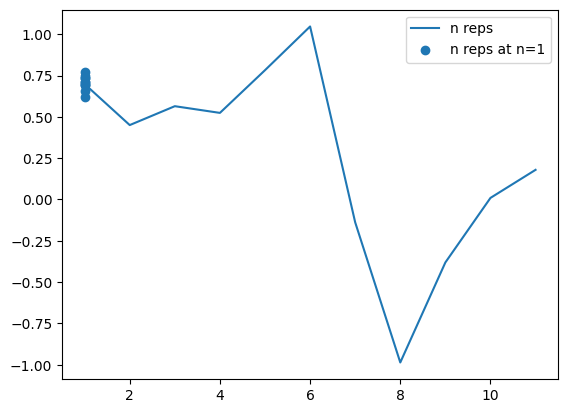

In [ ]:
plt.plot(n_reps, reward_data, label='n reps')
plt.scatter(n_reps_1, reward_data_1, label='n reps at n=1')
plt.legend()
plt.show()

In [ ]:
n = 100
print(q_env.target.gate_fidelity(q_env.target.target_operator.power(n), n_reps=n))

0.9999999999999801


In [ ]:
reward_data_1 = np.array(reward_data_1)

print(np.mean(reward_data_1))
print(np.std(reward_data_1))

0.6938467436856421
0.008160752356790134


In [ ]:
chi_matrix_1 = q_env.target.Chi(1) # N-reps = 1
chi_matrix_2 = q_env.target.Chi(2) # N-reps = 2

print(chi_matrix_1)
print(chi_matrix_1.shape)

[ 1.00000000e+00 -5.55111512e-17  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.55111512e-17  1.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  9.17099689e-01
  0.00000000e+00  0.00000000e+00  3.98657948e-01  0.00000000e+00
 -3.12297645e-18  5.55111512e-17  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.98657948e-01
  0.00000000e+00  0.00000000e+00 -9.17099689e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.55111512e-17 -3.12297

In [ ]:
print(chi_matrix_2)
print(chi_matrix_2.shape)

NameError: name 'chi_matrix_2' is not defined

In [ ]:
print(q_env.target.target_operator)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [ ]:
print(q_env.target.causal_cone_circuit)
print(q_env.target.input_states_choice)

   ┌──────────────┐┌──────────────┐     
0: ┤0             ├┤1             ├──■──
   │  rx(1.16, 2) ││  rx(3.92, 3) │┌─┴─┐
1: ┤1             ├┤0             ├┤ X ├
   └──────────────┘└──────────────┘└───┘
pauli4


In [ ]:
op = q_env.target.target_operator
op_2_true = q_env.target.target_operator.power(2, assume_unitary=True)
op_2_false = q_env.target.target_operator.power(2, assume_unitary=False)

op_mat = op.to_matrix()
op_mat_2 = op_mat @ op_mat

print(op)
print(op_2_true)
print(op_2_false)
print(op @ op)
print(np.conj(op_mat).T @ op_mat)
print(np.conj(op_mat_2).T @ op_mat_2)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))
Operator([[-0.4956506 -0.21211079j,  0.32348767+0.32499798j,
            0.2131011 +0.49334724j,  0.32348767+0.32499798j],
          [ 0.32348767+0.32499798j, -0.4956506 -0.21211079j,
            0.32348767+0.32499798j,  0.2131011 +0.49334724j],
          [ 0.2131011 +0.49334724j,  0.32348767+0.32499798j,
           -0.4956506 -0.21211079j,  0.32348767+0.32499798j],
          [ 0.32348767+0.32499798j,  0.2131011 +0.49334724j,
            0.32348767+0.3249

In [ ]:
chi_1 = q_env.target.Chi(10)
chi_1_mat = chi_1.reshape(16, 16)
eigenvalues_1, eigenvectors = np.linalg.eigh(chi_1_mat)
print(eigenvalues_1)

[-1.3382633  -0.98861062 -0.96954795 -0.3944121   0.04253252  0.33318432
  0.45722133  1.          1.          1.          1.          1.01087156
  1.02993423  1.24120574  1.35810128  1.53185754]


In [ ]:
dim = 2**q_env.target.causal_cone_size
probabilities = chi_1**2 / dim**2
print(probabilities)
print(np.sum(probabilities))

[6.25000000e-02 1.20370622e-33 2.97176727e-34 0.00000000e+00
 1.36855872e-32 9.75002034e-34 5.92566702e-35 8.69395622e-35
 4.81482486e-35 9.31109075e-35 1.08333559e-34 4.33334237e-34
 4.81482486e-35 4.81482486e-35 8.89731674e-35 4.81482486e-35
 1.20370622e-33 6.25000000e-02 1.20370622e-35 1.20370622e-35
 1.45648452e-33 1.37617945e-32 4.81482486e-35 1.20370622e-35
 7.52316385e-35 4.33334237e-34 8.56935382e-34 6.77084746e-36
 4.81482486e-35 0.00000000e+00 1.08333559e-34 3.00926554e-34
 1.08333559e-34 3.00956107e-35 3.87297508e-02 1.04699385e-02
 4.81482486e-35 4.81482486e-35 2.83037224e-03 1.04699385e-02
 1.95208295e-35 3.00926554e-34 4.81482486e-35 2.87247033e-34
 3.00926554e-34 3.40822126e-34 0.00000000e+00 5.89816045e-34
 0.00000000e+00 3.27895364e-37 1.04699385e-02 3.87297508e-02
 4.33334237e-34 3.20929501e-35 1.04699385e-02 2.83037224e-03
 0.00000000e+00 1.92592994e-34 2.46947354e-34 1.92592994e-34
 1.92592994e-34 1.08656704e-34 7.70371978e-34 1.92592994e-34
 1.37872439e-32 9.750020

In [ ]:
non_zero_indices = np.nonzero(probabilities)[0]  # Filter out zero probabilities
non_zero_probabilities = probabilities[non_zero_indices]

print(len(non_zero_probabilities))
print(np.sum(non_zero_probabilities))

236
0.9999999999999973


In [ ]:
dfe_precision = (0.1, 0.1)
eps, delta = dfe_precision
pauli_sampling = int(np.ceil(1 / (eps**2 * delta)))
print(pauli_sampling)

1000


In [ ]:
print(q_env.target.target_operator)

Operator([[-0.31912253+0.j        ,  0.        +0.20924857j,
            0.        -0.77297464j, -0.50683929+0.j        ],
          [-0.50683929+0.j        ,  0.        -0.77297464j,
            0.        +0.20924857j, -0.31912253+0.j        ],
          [ 0.        -0.77297464j, -0.50683929+0.j        ,
           -0.31912253+0.j        ,  0.        +0.20924857j],
          [ 0.        +0.20924857j, -0.31912253+0.j        ,
           -0.50683929+0.j        ,  0.        -0.77297464j]],
         input_dims=(2, 2), output_dims=(2, 2))


In [ ]:
from qiskit.quantum_info import pauli_basis

n_qubits = q_env.target.causal_cone_size

basis = pauli_basis(num_qubits=n_qubits)
print(len(basis))
print(basis)

16
['II', 'IX', 'IY', 'IZ', 'XI', 'XX', 'XY', 'XZ', 'YI', 'YX', 'YY', 'YZ',
 'ZI', 'ZX', 'ZY', 'ZZ']


In [ ]:
samples, q_env.config.reward_config._pauli_shots = np.unique(
    q_env.config.reward_config.fiducials_rng.choice(
        non_zero_indices, size=pauli_sampling, p=non_zero_probabilities
    ),
    return_counts=True,
)

In [ ]:
print(samples)

[  0  17  34  35  38  39  50  51  54  55  68  85  98  99 102 103 114 115
 118 119 137 140 152 157 174 175 190 191 200 205 217 220 234 235 250 251]


In [ ]:
print([chi_1[p] for p in samples])

[0.9999999999999987, 0.9999999999999987, 0.7871950287463572, -0.40929086902028267, -0.21280497125364106, -0.40929086902028256, 0.40929086902028267, 0.7871950287463572, 0.4092908690202826, -0.21280497125364103, 0.9999999999999987, 0.9999999999999987, -0.21280497125364106, -0.4092908690202826, 0.7871950287463572, -0.40929086902028267, 0.4092908690202826, -0.21280497125364106, 0.40929086902028267, 0.7871950287463572, 0.46118278726313133, 0.8869995031795723, 0.4611827872631314, 0.8869995031795723, 0.8869995031795723, -0.46118278726313144, 0.46118278726313144, 0.8869995031795723, -0.8869995031795722, 0.4611827872631314, -0.8869995031795723, 0.4611827872631314, -0.8869995031795723, 0.46118278726313144, -0.46118278726313144, -0.8869995031795723]


In [ ]:
reward_factor = [execution_config.c_factor / (dim * chi_1[p]) for p in samples]
print(reward_factor)
print(probabilities)

[0.25000000000000033, 0.25000000000000033, 0.3175833063861392, -0.6108125514708492, -1.1747845857511778, -0.6108125514708493, 0.6108125514708492, 0.3175833063861392, 0.6108125514708492, -1.1747845857511778, 0.25000000000000033, 0.25000000000000033, -1.1747845857511778, -0.6108125514708492, 0.3175833063861392, -0.6108125514708492, 0.6108125514708492, -1.1747845857511778, 0.6108125514708492, 0.3175833063861392, 0.5420844118741158, 0.28184908684147, 0.5420844118741157, 0.28184908684147, 0.28184908684147, -0.5420844118741156, 0.5420844118741156, 0.28184908684147, -0.28184908684147003, 0.5420844118741157, -0.28184908684147, 0.5420844118741157, -0.28184908684147, 0.5420844118741156, -0.5420844118741156, -0.28184908684147]
[6.25000000e-02 1.20370622e-33 2.97176727e-34 0.00000000e+00
 1.36855872e-32 9.75002034e-34 5.92566702e-35 8.69395622e-35
 4.81482486e-35 9.31109075e-35 1.08333559e-34 4.33334237e-34
 4.81482486e-35 4.81482486e-35 8.89731674e-35 4.81482486e-35
 1.20370622e-33 6.25000000e-02

In [ ]:
print(np.trace(chi_1_mat))

7.314074539437925


In [ ]:
from qiskit.quantum_info import Operator, DensityMatrix, Pauli, pauli_basis
import numpy as np

def compute_choi_matrix(gate):
    """
    Compute the Choi matrix of a quantum gate.

    Args:
        gate: Quantum gate (Operator, Gate, or QuantumCircuit).

    Returns:
        Choi matrix of the gate.
    """
    if not isinstance(gate, Operator):
        gate = Operator(gate)  # Convert to Operator if necessary

    d = 2**gate.num_qubits  # Dimension of the system
    basis = pauli_basis(num_qubits=gate.num_qubits)  # Pauli basis

    # Construct the maximally entangled state |Φ⟩
    Phi = np.zeros(d**2, dtype=complex)
    for i in range(d):
        Phi[i * d + i] = 1 / np.sqrt(d)

    # Compute the Choi matrix: Λ = (I ⊗ E)(|Φ⟩⟨Φ|)
    choi_matrix = np.zeros((d**2, d**2), dtype=complex)
    for i in range(d):
        for j in range(d):
            # Construct |i⟩⟨j| as a density matrix
            P_ij = np.zeros((d, d), dtype=complex)
            P_ij[i, j] = 1

            # Apply the gate to |i⟩⟨j|
            E_ij = gate.compose(Operator(P_ij)).data  # Evolve |i⟩⟨j| under the gate

            # Add to the Choi matrix
            choi_matrix += np.kron(np.outer(Phi[i], Phi[j]), E_ij)

    return choi_matrix

def compute_characteristic_function(choi_matrix):
    """
    Compute the characteristic function (Pauli coefficients) from the Choi matrix.

    Args:
        choi_matrix: Choi matrix of the quantum channel.

    Returns:
        Characteristic function (Pauli coefficients) as a 1D array.
    """
    d_squared = choi_matrix.shape[0]
    d = int(np.sqrt(d_squared))  # Dimension of the system
    basis = pauli_basis(num_qubits=int(np.log2(d)))  # Pauli basis

    # Compute the Pauli coefficients: χ[p] = Tr(Λ P_p) / d
    chi = np.zeros(d_squared, dtype=complex)
    for p, pauli in enumerate(basis):
        P_p = Operator(pauli).data  # Pauli operator as a matrix
        chi[p] = np.trace(choi_matrix @ np.kron(P_p, P_p)) / d

    # Ensure χ is real (imaginary part should be negligible)
    if not np.allclose(np.imag(chi), 0, atol=1e-10):
        raise ValueError("Imaginary part of χ is non-negligible.")
    chi = np.real(chi)

    return chi

def compute_entanglement_fidelity(gate):
    """
    Compute the entanglement fidelity of a quantum gate using the DFE approach.

    Args:
        gate: Quantum gate (Operator, Gate, or QuantumCircuit).

    Returns:
        Entanglement fidelity of the gate.
    """
    # Step 1: Compute the Choi matrix
    choi_matrix = compute_choi_matrix(gate)

    # Step 2: Compute the characteristic function (Pauli coefficients)
    chi = compute_characteristic_function(choi_matrix)

    # Step 3: Compute the entanglement fidelity
    entanglement_fidelity = np.sum(chi**2)

    return entanglement_fidelity

In [ ]:
from qiskit.circuit.library import CXGate

# Example: Compute entanglement fidelity of the CNOT gate
cnot_gate = CXGate()
fidelity = compute_entanglement_fidelity(cnot_gate)
print(f"Entanglement fidelity of CNOT gate: {fidelity:.6f}")

ValueError: operands could not be broadcast together with shapes (16,16) (4,4) (16,16) 

In [22]:
from qiskit.circuit.library import CXGate

# Example: Compute entanglement fidelity of the CNOT gate
cnot_gate = CXGate()
cnot_op = cnot_gate.to_matrix()

print(cnot_op)

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]]


In [43]:
x_gate = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 1, 0]])
print(x_gate)

[[1 0 0 0]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]]


In [26]:
target_op = q_env.target.target_operator.to_matrix()

print(target_op.shape)
print(cnot_op.shape)

(4, 4)
(4, 4)


In [27]:
print(cnot_op)
print(target_op)

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]]
[[-0.31912253+0.j          0.        +0.20924857j  0.        -0.77297464j
  -0.50683929+0.j        ]
 [-0.50683929+0.j          0.        -0.77297464j  0.        +0.20924857j
  -0.31912253+0.j        ]
 [ 0.        -0.77297464j -0.50683929+0.j         -0.31912253+0.j
   0.        +0.20924857j]
 [ 0.        +0.20924857j -0.31912253+0.j         -0.50683929+0.j
   0.        -0.77297464j]]


In [34]:
from qiskit.circuit.library import RXGate

rxgate_1 = RXGate(1.16).to_matrix()
rxgate_2 = RXGate(3.92).to_matrix()

id_gate = np.eye(2, 2)

rx_1 = np.kron(rxgate_1, id_gate)
rx_2 = np.kron(id_gate, rxgate_2)

print((rx_1 @ rx_2).shape)

(4, 4)


In [35]:
print((rx_1 @ rx_2))

[[-0.31739723+0.j          0.        -0.77390488j  0.        +0.20794865j
  -0.50703806+0.j        ]
 [ 0.        -0.77390488j -0.31739723+0.j         -0.50703806+0.j
   0.        +0.20794865j]
 [ 0.        +0.20794865j -0.50703806+0.j         -0.31739723+0.j
   0.        -0.77390488j]
 [-0.50703806+0.j          0.        +0.20794865j  0.        -0.77390488j
  -0.31739723+0.j        ]]


In [36]:
print((rx_2 @ rx_1))

[[-0.31739723+0.j          0.        -0.77390488j  0.        +0.20794865j
  -0.50703806+0.j        ]
 [ 0.        -0.77390488j -0.31739723+0.j         -0.50703806+0.j
   0.        +0.20794865j]
 [ 0.        +0.20794865j -0.50703806+0.j         -0.31739723+0.j
   0.        -0.77390488j]
 [-0.50703806+0.j          0.        +0.20794865j  0.        -0.77390488j
  -0.31739723+0.j        ]]


In [46]:
print((rx_1 @ rx_2 @ x_gate))

[[-0.31739723+0.j          0.        -0.77390488j -0.50703806+0.j
   0.        +0.20794865j]
 [ 0.        -0.77390488j -0.31739723+0.j          0.        +0.20794865j
  -0.50703806+0.j        ]
 [ 0.        +0.20794865j -0.50703806+0.j          0.        -0.77390488j
  -0.31739723+0.j        ]
 [-0.50703806+0.j          0.        +0.20794865j -0.31739723+0.j
   0.        -0.77390488j]]


In [45]:
print(target_op)

[[-0.31912253+0.j          0.        +0.20924857j  0.        -0.77297464j
  -0.50683929+0.j        ]
 [-0.50683929+0.j          0.        -0.77297464j  0.        +0.20924857j
  -0.31912253+0.j        ]
 [ 0.        -0.77297464j -0.50683929+0.j         -0.31912253+0.j
   0.        +0.20924857j]
 [ 0.        +0.20924857j -0.31912253+0.j         -0.50683929+0.j
   0.        -0.77297464j]]
